This is an implementation of Gaussian Bernouille Boltzmann machine above Mnist dataset. 

We use the provided gradient descent algorithm.

Without regularizaiton of dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
#If not installed utils
'''
import urllib.request
response = urllib.request.urlopen('http://deeplearning.net/tutorial/code/utils.py')
content = response.read().decode('utf-8')
target = open('utils.py', 'w')
target.write(content)
target.close()
'''
import os
import timeit
import numpy as np
import tensorflow as tf
from PIL import Image
from utils import tile_raster_images
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
class RBM(object):
    def __init__(self, input=None, n_visible=784, n_hidden=500, W=None, hbias=None, vbias=None):
        '''
        input: tensor, input tensor [None, n_visible];
        n_visible: int, numbre of visible units
        n_hidden:   int, number of hidden units
        W: weight
        W, hbias, vbias: Tensor, (tf.Variable);
        '''
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if input is None:
            input = tf.placeholder(dtype=tf.float32, shape=[None, self.n_visible]) # None should be batch size, can be any value.
        self.input = input

        if W is None:
            # I can't find any article about this initialisation of W, many tutorials just use it without explication.
            # One tutorial says that it's Xavier initialisation, but not the same form
            bounds = 4.0 * np.sqrt(6.0 / (self.n_visible + self.n_hidden))
            W = tf.Variable(tf.random_uniform([self.n_visible, self.n_hidden], minval=-bounds,
                                              maxval=bounds), dtype=tf.float32)
        # Or we can attribute W  with small random values
        # if weight is None:
            #self.weight = np.random.rand(self.n_hidden,self.n_visible)*0.1     
        if hbias is None:
            hbias = tf.Variable(tf.zeros([self.n_hidden,]), dtype=tf.float32)

        if vbias is None:
            vbias = tf.Variable(tf.zeros([self.n_visible,]), dtype=tf.float32)
        
        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.sigma= 1.0
        self.params = [self.W, self.hbias, self.vbias]
    
    def propup(self, v):  # prop: propagation or probability
        # P(hi=1|v)
        # if a batch has i data points, every data point has j coordinates(visible values), 
        # then v is a matrix i*j 
        return tf.nn.sigmoid(tf.matmul(v/self.sigma, self.W) + self.hbias)
    def propdown(self, h):
        activation=tf.matmul(h*self.sigma, tf.transpose(self.W))+self.vbias
        return activation
    
    def sample_h_given_v(self, v_sample):
        h_mean=self.propup(v_sample)
        h_sample = tf.nn.relu(tf.sign(h_mean - tf.random_uniform(tf.shape(h_mean))))
        return h_mean, h_sample
    def sample_v_given_h(self, h_sample):
        v_mean=self.propdown(h_sample)
        v_sample=tf.random.normal(tf.shape(v_mean), mean=v_mean, stddev=self.sigma)
        return v_mean, v_sample

    def gibbs_vhv(self, v0_sample):
        #Implement one step of Gibbs sampling from the visible layer
        h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        return (h1_mean, h1_sample, v1_mean, v1_sample)
    
    def gibbs_hvh(self, h0_sample):
        #Implement one step of Gibbs sampling from the hidden layer
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return (v1_mean, v1_sample, h1_mean, h1_sample)

    def free_energy(self, v_sample):  # here v_sample is just one sample, not a batch.
        wx_b = tf.matmul(v_sample/self.sigma, self.W) + self.hbias
        vbias_term = tf.reduce_sum(tf.square(tf.subtract(v_sample, self.vbias)), axis=1)/((self.sigma**2)*2)
        hidden_term = tf.reduce_sum(tf.log(1.0 + tf.exp(wx_b)), axis=1)
        return -hidden_term + vbias_term   # ！！！注意这里是+号，与rbm不同

    #ops: operation
    def get_train_ops(self, learning_rate=0.1, k=1, persistent=None):
        """
        Contrastive Divergence
        learning_rate: float
        k: int, steps of gibbs sampling 
        persistent: Tensor, PCD(persistent contrastive divergence)
        """
        #positive phase ( the visible units' states are clamped to a particular binary state vector sampled from the training set )
        ph_mean, ph_sample = self.sample_h_given_v(self.input)
        #negative phase ( the network is allowed to run freely, i.e. no units have their state determined by external data)
        if persistent is None: 
            chain_start = ph_sample
        else: # In PCD, there existes one Markov chain per training batch
            chain_start = persistent

        # condition of tf.while_loop : i<k
        cond = lambda i, nv_mean, nv_sample, nh_mean, nh_sample: i < k
        body = lambda i, nv_mean, nv_sample, nh_mean, nh_sample: (i+1, ) + self.gibbs_hvh(nh_sample)
        # tf.while_loop()执行CD-k采样;即loop参数先传入cond判断条件是否成立,成立之后,把loop参数传入body执行操作,然后返回操作后的loop参数;
        i, nv_mean, nv_sample, nh_mean, nh_sample = tf.while_loop(cond, body, 
                                                    loop_vars=[tf.constant(0), tf.zeros(tf.shape(self.input)), 
                                                    tf.zeros(tf.shape(self.input)), tf.zeros(tf.shape(chain_start)), chain_start])

        
        # the rules of updating parameters:
        """
        update_W = self.W + learning_rate * (tf.matmul(tf.transpose(self.input), ph_mean) - 
                                tf.matmul(tf.transpose(nv_sample), nh_mean) ) / tf.to_float(tf.shape(self.input)[0])  # use probability
        update_vbias = self.vbias + learning_rate * (tf.reduce_mean(self.input - nv_sample, axis=0))   # use binary value
        update_hbias = self.hbias + learning_rate * (tf.reduce_mean(ph_mean - nh_mean, axis=0))       # use probability
        # assign new values;
        new_W = tf.assign(self.W, update_W)
        new_vbias = tf.assign(self.vbias, update_vbias)
        new_hbias = tf.assign(self.hbias, update_hbias)
        """
        # But here use gradient directly without using the rules above
        chain_end = tf.stop_gradient(nv_sample)   
        # cost function;
        cost =  tf.reduce_mean(self.free_energy(self.input)) - tf.reduce_mean(self.free_energy(chain_end)) + 0.01*tf.norm(self.W, ord=1)
        '''
        # gradient w.r.t. parameters
        gparams = tf.gradients(ys=[cost], xs=self.params)
        # update parameters
        new_params = []
        for gparam, param in zip(gparams, self.params):
            new_params.append(tf.assign(param, param - gparam*learning_rate))
        '''
        opt_func = tf.train.AdamOptimizer(learning_rate=learning_rate) 
        grad_and_params = opt_func.compute_gradients(cost, self.params)
        grad_and_params = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in grad_and_params]
        updt = opt_func.apply_gradients(grad_and_params)
        
        
        # 更新persistent;persistent存储的是最新的nh_sample(hidden layer采样值);
        if persistent is not None:
            new_persistent = [tf.assign(persistent, nh_sample)]
        else:
            new_persistent = []
        return updt , new_persistent  

    def get_reconstruction_cost(self):
        """cross-entropy between input and after the processus v -> h -> v"""
        # v -> h;
        activation_h = self.propup(self.input)
        # h -> v;
        activation_v = self.propdown(activation_h)
        # 这一步是为了避免Nan(使下界clip_value_min=1e-30);
        activation_v_clip = tf.clip_by_value(activation_v, clip_value_min=1e-30, clip_value_max=1.0)
        # 1.0 - activation_v;
        reduce_activation_v_clip = tf.clip_by_value(1.0 - activation_v, clip_value_min=1e-30, clip_value_max=1.0)
        # cross_entropy;
        cross_entropy = -tf.reduce_mean(tf.reduce_sum(self.input*(tf.log(activation_v_clip)) + 
                                    (1.0 - self.input)*(tf.log(reduce_activation_v_clip)), axis=1))
        return cross_entropy   
    def construction_error(self,inpt):
        h_probs=self.propup(inpt)
        activation_v = self.propdown(h_probs)
        error=tf.reduce_mean(tf.reduce_sum(tf.square(inpt-activation_v),axis=1))
        return error  
    
    def reconstruct(self, v):
        # v -> h -> v
        #h=self.sample_h_given_v(v)  #!!!!不知道哪个好用
        h = self.propup(v)
        return self.propdown(h) 

if __name__ == "__main__":

    # define input
    x = tf.placeholder(tf.float32, shape=[None, 784])
    tf.set_random_seed(seed=99999)
    np.random.seed(123)

    n_visible, n_hidden = 784, 500
    rbm = RBM(x, n_visible=n_visible, n_hidden=n_hidden)

    learning_rate = 0.001 #0.01就全是黑的了
    batch_size = 20
    training_epochs = 50
    display_step = 1
    k=1

    #cost = rbm.get_reconstruction_cost()
    construction_error = rbm.construction_error(x)
    # persistent_chain ∈ [batch_size, n_hidden];
    persistent_chain = tf.Variable(tf.zeros([batch_size, n_hidden]), dtype=tf.float32)
    # k=1
    train_ops = rbm.get_train_ops(learning_rate=learning_rate, k=k, persistent=persistent_chain)

    init = tf.global_variables_initializer()

    output_folder = "GBRBM_MNIST_v1_OUTPUT_lr=0.001"
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    os.chdir(output_folder)


    print("Start training...")

    sess=tf.Session()
    start_time = timeit.default_timer()
    sess.run(init)
    for epoch in range(training_epochs):
        #avg_cost = 0.0
        avg_construction_error=0.0
        batch_num = int(mnist.train.num_examples / batch_size)
        for i in range(batch_num):
            x_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_ops, feed_dict={x: x_batch})
            #avg_cost += sess.run(cost, feed_dict={x: x_batch,}) / batch_num
            avg_construction_error += sess.run(construction_error, feed_dict={x: x_batch}) / batch_num
        if epoch % display_step == 0:
            #print("Epoch {0} cost: {1}".format(epoch, avg_cost))
            print("Epoch {0}, reconstruction error: {1}".format(epoch, avg_construction_error))
        # store the value of W by image
        # the image of W is similar with image of number because one unit in hidden layer can represent a image(it has a link with all the visible units)
        image = Image.fromarray(
        tile_raster_images(
            X=sess.run(tf.transpose(rbm.W)),
            img_shape=(28, 28),
            tile_shape=(10, 10),
            tile_spacing=(1, 1)))
        image.save("new_filters_at_epoch_{0}.png".format(epoch))

    end_time = timeit.default_timer()
    training_time = end_time - start_time
    print("Finished!")
    print("k={0},  epochs= {1}, The training ran for {2} minutes.".format(k, training_epochs, training_time/60,))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start training...
Epoch 0, reconstruction error: 323.5863641405967
Epoch 1, reconstruction error: 50.839473638361106
Epoch 2, reconstruction error: 48.03812193159617
Epoch 3, reconstruction error: 41.37298748779295
Epoch 4, reconstruction error: 39.01465261494031
Epoch 5, reconstruction error: 38.400987039045965
Epoch 6, reconstruction error: 38.01988722783863
Epoch 7, reconstruction error: 37.75477030112518
Epoch 8, reconstruction error: 37.58383505734536
Epoch 9, reconstruction error: 37.43584543887047
Epoch 10, reconstruction error: 37.39156732385811
Epoch 11, reconstruction error: 37.31073697038127
Epoch 12, reconstruction error: 37.272647549715884
Epoch 13, reconstruction error: 37.20201773279364
Epoch 14, reconstruction error: 37.16295303899581
Epoch 15, reconstruction error: 37.13351969979022
Epoch 16, reconstruction error: 37.082957877419176
Epoch 17, reconstr

# Reconstruction

In [3]:
n_chains = 20
n_samples = 10
n_iter = 1
# chose 'n_chains' examples randomly
# test_indexs = np.random.randint(mnist.test.num_examples,size=(n_chains))
test_samples = np.copy(mnist.test.images[0:n_chains])
test_samples_whiteline = np.copy(test_samples)
test_samples_gaussian=np.copy(test_samples)
for n in range(n_chains):
    for m in range(3*28):
        test_samples_whiteline[n,m]=1

for n in range(n_chains):
    for m in range(28*28):
        if np.random.rand() < 0.1 :
            test_samples_gaussian[n,m]=1-test_samples_gaussian[n,m]

Instructions for updating:
Use tf.cast instead.
...plotting sample 1
...plotting sample 2
...plotting sample 3
...plotting sample 4
...plotting sample 5
...plotting sample 6
...plotting sample 7
...plotting sample 8
...plotting sample 9
...plotting sample 10
finished


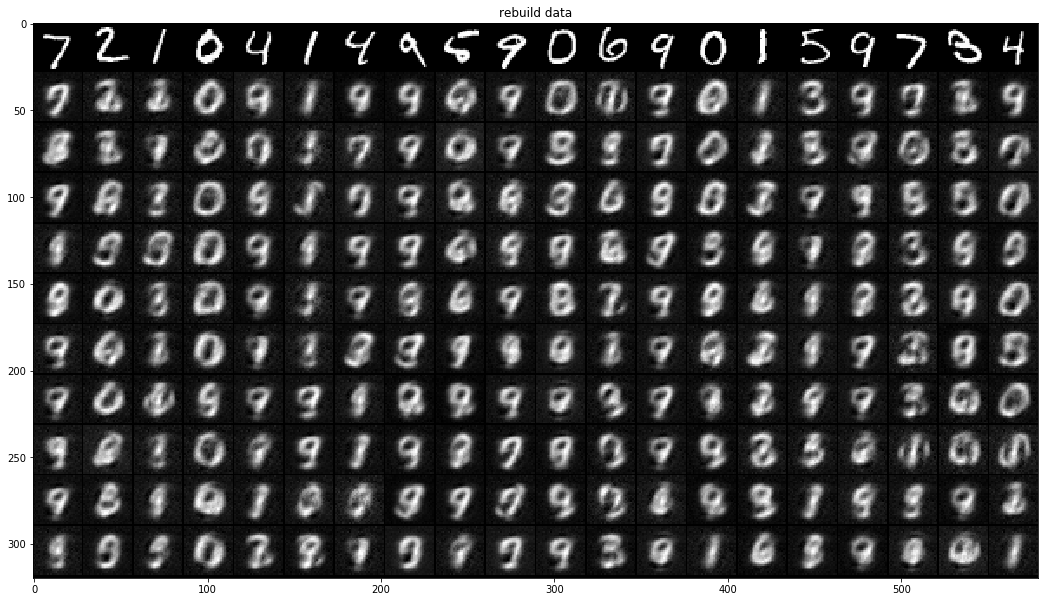

In [4]:
n_iter=1
# store the state of visible layer
persistent_v_chain = tf.Variable(tf.to_float(test_samples), dtype=tf.float32)


cond = lambda i, h_mean, h_sample, v_mean, v_sample: i < n_iter
body = lambda i, h_mean, h_sample, v_mean, v_sample: (i+1, ) + rbm.gibbs_vhv(v_sample)
i, h_mean, h_sample, v_mean, v_sample = tf.while_loop(cond, body, 
                                        loop_vars=[tf.constant(0), tf.zeros([n_chains, n_hidden]), 
                                        tf.zeros([n_chains, n_hidden]), tf.zeros(tf.shape(persistent_v_chain)), persistent_v_chain])
# update persistent_v_chain;
new_persistent_v_chain = tf.assign(persistent_v_chain, v_sample)
# store the sampled images
image_data = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data[0:28,:] = tile_raster_images(X=test_samples,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))

sess.run(tf.variables_initializer(var_list=[persistent_v_chain]))

for idx in range(1, n_samples+1):
    sample = sess.run(v_mean)
    sess.run(new_persistent_v_chain)
    print("...plotting sample", idx)
    image_data[idx*29:idx*29+28,:] = tile_raster_images(X=sample,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))              
image = Image.fromarray(image_data)
image.save("reconstruction.png".format(n_samples))
print("finished")

plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.figure(1)
plt.title('rebuild data') 
plt.imshow(image)
plt.set_cmap('gray') 

 # Three lines of white

...plotting sample 1
...plotting sample 2
...plotting sample 3
...plotting sample 4
...plotting sample 5
...plotting sample 6
...plotting sample 7
...plotting sample 8
...plotting sample 9
...plotting sample 10
finished


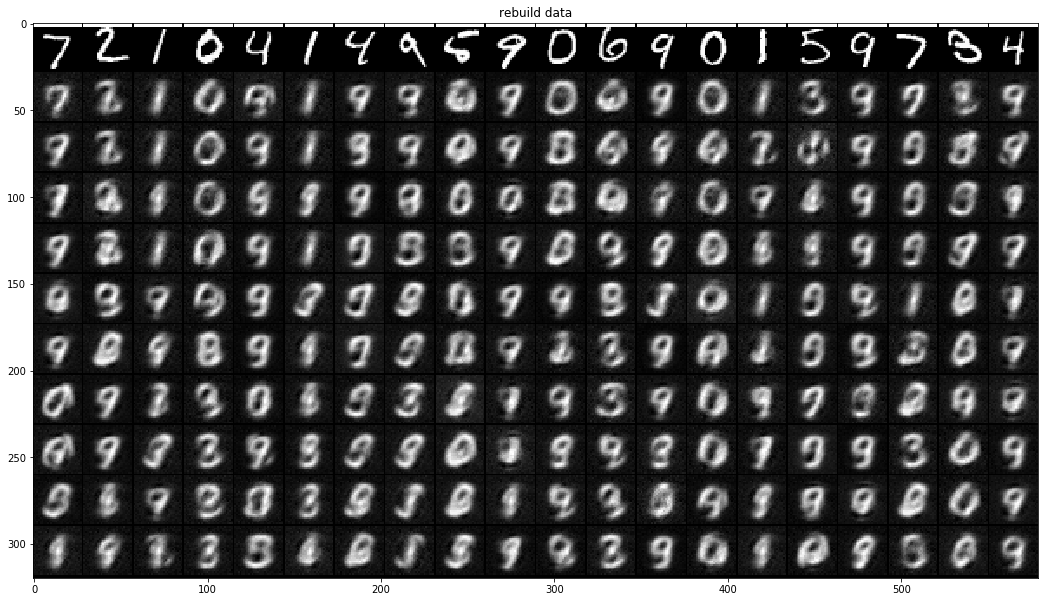

In [5]:
n_iter=1
# store the state of visible layer
persistent_v_chain = tf.Variable(tf.to_float(test_samples_whiteline), dtype=tf.float32)

cond = lambda i, h_mean, h_sample, v_mean, v_sample: i < n_iter
body = lambda i, h_mean, h_sample, v_mean, v_sample: (i+1, ) + rbm.gibbs_vhv(v_sample)
i, h_mean, h_sample, v_mean, v_sample = tf.while_loop(cond, body, 
                                        loop_vars=[tf.constant(0), tf.zeros([n_chains, n_hidden]), 
                                        tf.zeros([n_chains, n_hidden]), tf.zeros(tf.shape(persistent_v_chain)), persistent_v_chain])
# update persistent_v_chain;
new_persistent_v_chain = tf.assign(persistent_v_chain, v_sample)
# store the sampled images
image_data = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data[0:28,:] = tile_raster_images(X=test_samples_whiteline,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))

sess.run(tf.variables_initializer(var_list=[persistent_v_chain]))

for idx in range(1, n_samples+1):
    sample = sess.run(v_mean)
    sess.run(new_persistent_v_chain)
    print("...plotting sample", idx)
    image_data[idx*29:idx*29+28,:] = tile_raster_images(X=sample,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))              
image = Image.fromarray(image_data)
image.save("reconstruction_whiteline.png".format(n_samples))
print("finished")

plt.figure(2)
plt.title('rebuild data') 
plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.imshow(image)
plt.set_cmap('gray')

 # Noise gaussian

...plotting sample 1
...plotting sample 2
...plotting sample 3
...plotting sample 4
...plotting sample 5
...plotting sample 6
...plotting sample 7
...plotting sample 8
...plotting sample 9
...plotting sample 10
finished


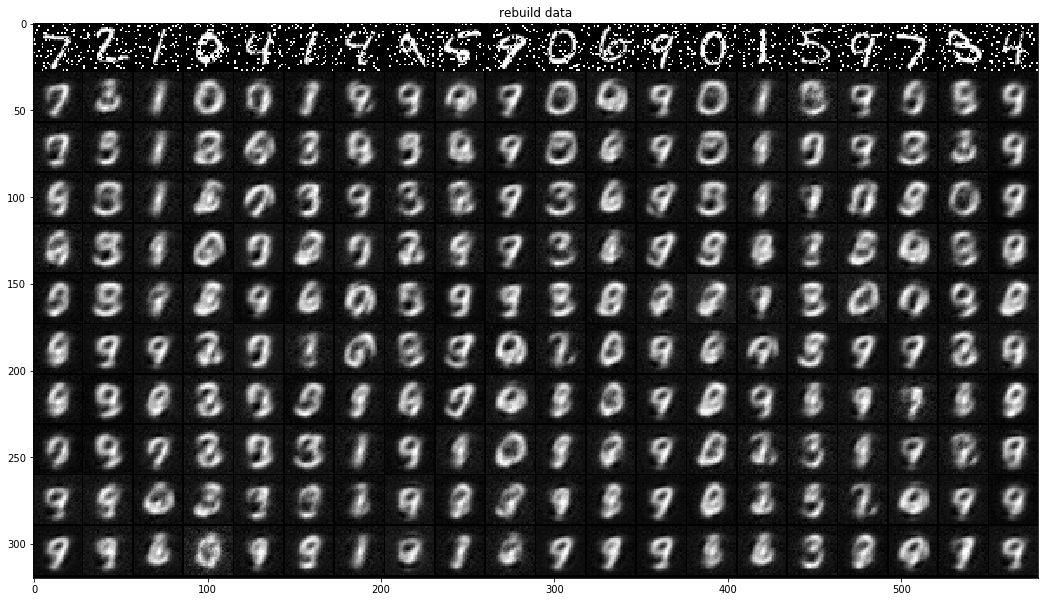

In [6]:
n_iter=1
# store the state of visible layer
persistent_v_chain = tf.Variable(tf.to_float(test_samples_gaussian), dtype=tf.float32)

cond = lambda i, h_mean, h_sample, v_mean, v_sample: i < n_iter
body = lambda i, h_mean, h_sample, v_mean, v_sample: (i+1, ) + rbm.gibbs_vhv(v_sample)
i, h_mean, h_sample, v_mean, v_sample = tf.while_loop(cond, body, 
                                        loop_vars=[tf.constant(0), tf.zeros([n_chains, n_hidden]), 
                                        tf.zeros([n_chains, n_hidden]), tf.zeros(tf.shape(persistent_v_chain)), persistent_v_chain])
# update persistent_v_chain;
new_persistent_v_chain = tf.assign(persistent_v_chain, v_sample)
# store the sampled images
image_data = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data[0:28,:] = tile_raster_images(X=test_samples_gaussian,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))

sess.run(tf.variables_initializer(var_list=[persistent_v_chain]))

for idx in range(1, n_samples+1):
    sample = sess.run(v_mean)
    sess.run(new_persistent_v_chain)
    print("...plotting sample", idx)
    image_data[idx*29:idx*29+28,:] = tile_raster_images(X=sample,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))              
image = Image.fromarray(image_data)
image.save("reconstruction_gaussian.png".format(n_samples))
print("finished")

plt.figure(3)
plt.title('rebuild data') 
plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.imshow(image)
plt.set_cmap('gray') 

In [7]:
writer=tf.summary.FileWriter('./GraphBMMNIST', graph=tf.get_default_graph())
writer.close()

In [8]:
#sess.close()